In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
#Load the dataset and explore.
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/train_data.csv
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/test_data.csv
    !ls -lah DATAPATH
    filepath = "DATAPATH/train_data.csv"
except ModuleNotFoundError:
    filepath = "Data/Sentiment and Emotion in Text/train_data.csv"

--2024-05-18 05:15:06--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/train_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2479133 (2.4M) [text/plain]
Saving to: ‘DATAPATH/train_data.csv.1’

train_data.csv.1    100%[===================>]   2.36M  --.-KB/s    in 0.05s   

2024-05-18 05:15:06 (47.1 MB/s) - ‘DATAPATH/train_data.csv.1’ saved [2479133/2479133]

--2024-05-18 05:15:06--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.github

In [36]:
df = pd.read_csv(filepath)
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [37]:
df.shape

(30000, 2)

In [38]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [39]:
df['sentiment'].value_counts()

sentiment
worry         7433
neutral       6340
sadness       4828
happiness     2986
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: count, dtype: int64

In [40]:
# let's create 2 dataset one will contain top 3 sentiment and other will have till surprise as a test data
shortlist = ['neutral' , 'worry' , 'happiness']
df_top_3 = df[df['sentiment'].isin(shortlist)]
df_top_3.shape

(16759, 2)

In [41]:
shortlist = ['sadness', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'relief']
df_till_relief = df[df['sentiment'].isin(shortlist)]
df_till_relief.shape

(28564, 2)

### Text pre-processing

In [42]:
# let's see first one tweet
df['content'].sample()

25839    its gonna be a great week! dallas next weekend!!!
Name: content, dtype: object

Tweet are different the text.
few thing we need to process.
* Removing mentions, and urls if they are in the tweets.
* we can use NLTK's Tweet tokenizer instead of a regular one
* stopwords removal since i don't think the stopwords matter of the sentiment as compare to the actual words that exhibit those emotions.
* also we need to take care of numbers also

In [43]:
# striphandles remove the presonal infos like tweeter handles since they don't contribute to emotions.
# preserve_case=False converts everything to lowercase
tweeter = TweetTokenizer(strip_handles=True , preserve_case=False)
mystopwords = set(stopwords.words('english'))


# function to tokenize tweets, remove stopwords and numbers.
# Keeping punctuations and emoticon symbols could be relevant since they help understand emotion better.

def preprocess_corpus(text):
  def remove_stop_digits(tokens):
    return [token for token in tokens if token not in mystopwords and token.isdigit()]

  return [remove_stop_digits(tweeter.tokenize(content)) for content in text]

In [44]:
df_top_3_preprocessed = preprocess_corpus(df_top_3['content'])
df_top_3_preprocessed_cats = df_top_3['sentiment']

df_till_relief_preprocessed = preprocess_corpus(df_till_relief['content'])
df_till_relief_preprocessed_cats = df_till_relief['sentiment']

In [46]:
len(df_till_relief_preprocessed), len(df_till_relief_preprocessed_cats)

(28564, 28564)

In [52]:
# Split the dataset into train adn test
# we will first use the top 3 dataset then til relief one
train_data , test_data , train_cats , test_cats = train_test_split(
    df_top_3_preprocessed,
    df_top_3_preprocessed_cats,
    random_state = 1234,
    train_size = 0.8
)

# representation using doc2vec
train_doc2vec = [TaggedDocument((d),tags=[str(i)]) for i , d in enumerate(train_data)]

# train the doc2vec model
model = Doc2Vec(
    vector_size=50,
    alpha=0.025,
    min_count=5,
    dm=1,
    epochs=100
)
model.build_vocab(train_doc2vec)
model.train(
    train_doc2vec,
    total_examples = model.corpus_count,
    epochs = model.epochs
)
model.save("d2v.model")
print("model saved")

model saved


In [54]:
# make prediction on the feature representation we made for train and test data using are model
model = Doc2Vec.load('d2v.model')

# make stable representation
train_vectors = [model.infer_vector(list_of_tokens , epochs=50) for list_of_tokens in train_data]
test_vectors = [model.infer_vector(list_of_tokens , epochs=50) for list_of_tokens in test_data]

#use any regular classifier like logistic regression
from sklearn.linear_model import LogisticRegression

myclass = LogisticRegression(class_weight="balanced") # since classes are not balanced
myclass.fit(train_vectors , train_cats)

preds = myclass.predict(test_vectors)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_cats , preds))

              precision    recall  f1-score   support

   happiness       0.18      0.23      0.20       584
     neutral       0.39      0.49      0.44      1268
       worry       0.48      0.33      0.39      1500

    accuracy                           0.37      3352
   macro avg       0.35      0.35      0.34      3352
weighted avg       0.39      0.37      0.38      3352



### this code is for relief

In [55]:
# Split the dataset into train adn test
# we will first use the top 3 dataset then til relief one
train_data , test_data , train_cats , test_cats = train_test_split(
    df_till_relief_preprocessed,
    df_till_relief_preprocessed_cats,
    random_state = 1234,
    train_size = 0.8
)

# representation using doc2vec
train_doc2vec = [TaggedDocument((d),tags=[str(i)]) for i , d in enumerate(train_data)]

# train the doc2vec model
model = Doc2Vec(
    vector_size=50,
    alpha=0.025,
    min_count=5,
    dm=1,
    epochs=100
)
model.build_vocab(train_doc2vec)
model.train(
    train_doc2vec,
    total_examples = model.corpus_count,
    epochs = model.epochs
)
model.save("d2v.model")
print("model saved")

model saved


In [56]:
# make prediction on the feature representation we made for train and test data using are model
model = Doc2Vec.load('d2v.model')

# make stable representation
train_vectors = [model.infer_vector(list_of_tokens , epochs=50) for list_of_tokens in train_data]
test_vectors = [model.infer_vector(list_of_tokens , epochs=50) for list_of_tokens in test_data]

#use any regular classifier like logistic regression
from sklearn.linear_model import LogisticRegression

myclass = LogisticRegression(class_weight="balanced") # since classes are not balanced
myclass.fit(train_vectors , train_cats)

preds = myclass.predict(test_vectors)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_cats , preds))

              precision    recall  f1-score   support

         fun       0.04      0.23      0.07       217
   happiness       0.12      0.07      0.09       596
        hate       0.05      0.05      0.05       234
        love       0.07      0.23      0.11       457
     neutral       0.27      0.03      0.05      1272
      relief       0.05      0.15      0.07       210
     sadness       0.17      0.08      0.11       973
    surprise       0.06      0.19      0.09       307
       worry       0.23      0.02      0.03      1447

    accuracy                           0.08      5713
   macro avg       0.12      0.12      0.07      5713
weighted avg       0.17      0.08      0.07      5713



In [60]:
cm = confusion_matrix(test_cats , preds)

In [61]:
shortlist

['sadness',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'relief']

<Axes: >

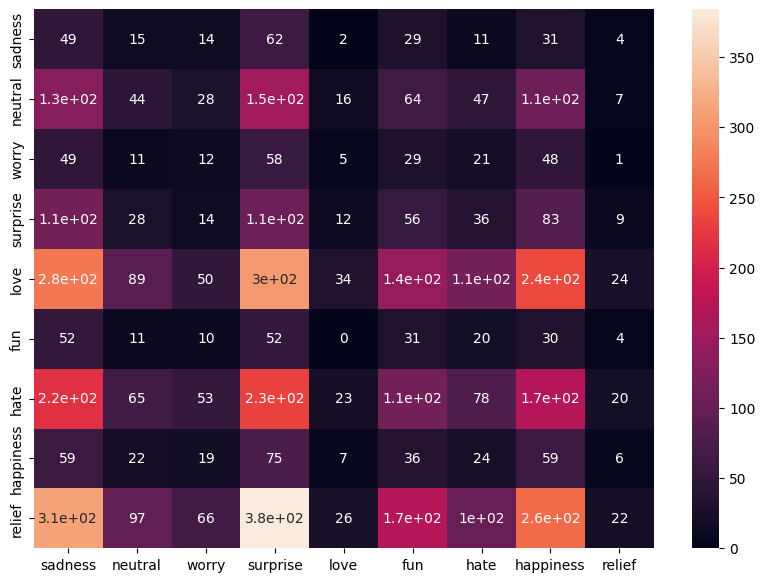

In [64]:
#plot the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = [i for i in shortlist],
                     columns = [i for i in shortlist])

plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)